# Investigate boundaries of EUC in INALT20

For both, model and observations we calculate the central position $ Y_{CM} $ and along-pathway intensity $ INT $ of zonal currents using the algorithm of Hsin (2012). 

\begin{equation}
Y_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} y\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Y_CM}
\end{equation}

\begin{equation}
INT(x,t) = \int_{Z_l}^{Z_u} \int_{Y_{CM}-W}^{Y_{CM}+W} u(x,y,z,t)\ dy\ dz 
\label{equ_INT}
\end{equation}


where $y$ is latitude, $x$ is longitude, $u$ is zonal velocity, $z$ is depth, $t$ is time, $Z_u$ ($Z_l$) is upper (lower) boundary of the flow, $Y_N$ ($Y_S$) is northern (southern) limit of the flow, and $W$ is the half mean width of the flow.

![](../figures/INALT20_obs_23w_comparison/1_INALT20_obs_23w_1999_2012.png)

For transport calculation of the EUC Brandt et al. (2014) used the following boundary conditions:

$Z_u = 30\,$m, $Z_l = 300\,$m, $Y_N = 1.2^{\circ}$N, $Y_S = 1.2^{\circ}$S

To be consistent with the mooring reconstructed transport of Brandt et al (2014), I will first use $Y_N = 1.2^{\circ}$N, $Y_S = 1.2^{\circ}$S as meridional boundaries for the transport calculations. That will be compared to calculations with a variable meridional boundary. Based on the 23$^{\circ}$W section, I choose $W = 2^{\circ}$.

The depth of the EUC core $Z_{CM}$ will be estimated similar to $Y_{CM}$:

\begin{equation}
Z_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} z\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Z_CM}
\end{equation}

Think about variable depth boundaries. Or boundaries define by density. Because is the model we calculate the EUC transport along the equator, not only at 23W.

- [ ] literature review about depth of EUC in western and eastern basin.


## Tech preample

In [44]:
%matplotlib inline
import os
import dask
import cmocean
import datetime
import cftime
import gsw
import seawater as sw
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from pathlib import Path
from scipy.io import loadmat
from datetime import datetime

## Dask jobqueue and client
To controle the resources used for parallel computations on computing nodes.

In [45]:
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4, memory='24GB',
    processes=1, # Dask workers per job
    # SLURM job script things
    queue='cluster', walltime='01:30:00',
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',
    log_directory='./slurm-logs'
)

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33789 instead
  http_address["port"], self.http_server.port


In [46]:
from dask.distributed import Client

In [47]:
client = Client(cluster)
# client = Client(n_workers=1, threads_per_worker=8, memory_limit=12e9)
client

Client Scheduler: tcp://172.18.4.13:43687 Dashboard: http://172.18.4.13:33789/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [48]:
cluster.adapt(
    minimum=1, maximum=20,
)

## Output parameters

In [49]:
out_dir_data = Path('../data/INALT20_EUC_boundaries/')
Path(out_dir_data).mkdir(parents=True, exist_ok=True)
out_data_1 = 'EUC_boundaries'

out_dir_fig = Path('../figures/INALT20_EUC_boundaries/')
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
out_fig_1 = 'INALT_JRA_CORE_EUC_zonal'
out_fig_2 = 'INALT_JRA_EUC_zonal'
out_fig_3 = 'INALT_CORE_EUC_zonal'
out_fig_4 = 'INALT_JRA_CORE_EUC_merid'
out_fig_5 = 'INALT_JRA_EUC_merid'
out_fig_6 = 'INALT_CORE_EUC_merid'
fig_format = '.png'

savefig = 1; #set one if figures should be saved

## Input parameters
For INALT20 

In [50]:
run_calc_1M = 1 #set 1 if annual mean should be recalculated
run_calc_1Y = 0 #set 1 if annual mean should be recalculated
global_data_path = Path("/sfs/fs1/work-geomar1/smomw044/")
JRA_path = "INALT20.L46-KFS10X"
exp_id = "INALT20.L46-KFS10?"

CORE_path = "shared/INALT20.L46-KFS044-S"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

restr_years1 = "20[0-1][0-9]"  # restricts to 2010 and 2011

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = 9
chu_t = 1

# variables wanted
vars_want = ['vosaline','votemper','vozocrtx']

Calculation of EUC - Boundary conditions

In [51]:
lonlim = [-40, 0]
latlim = [-2.5, 2.5]
zlim = [0, 400]

## integers
xclim1 = 590
xclim2 = 1389 
yclim1 = 1579
yclim2 = 1679 

# for nc-file attrs
lat_s = latlim[0]
lat_n = latlim[1]
lon_e = lonlim[0]
lon_w = lonlim[1]

p_ref = 0 # dbar; reference pressure for potential density calculation

Find relevant data files for INALT20

## Calculate density

In [52]:
def calc_pdens_sw(p_ref,ds):
    """ Calculates potential density using the EOS-80 seawater library
    Parameters
    ----------
    pref : int
    reference pressure for potential density calculation
    ds : xr.DataSet containing NEMO3 model output
      ds.deptht  : xr.DataArray (depth in m, positive downwards)
      ds.gphit  : xr.DataArray (latitude grid in degN)
      ds.vosaline  : xr.DataArray (practical salinity(eos 80))
      ds.votemper  : xr.DataArray (potential temp (eos 80))
   
    Returns
    -------
    xr.DataArray
    Data array of potential density calculated using the EOS-80 seawater library [kg/m^3], same dimension as input data arrays
    """
    
    # calculate pressure from depth (z, pos. upward): gsw.p_from_z(z,lat)
    p = xr.apply_ufunc(
    sw.eos80.pres,
    -abs(ds.deptht),ds.gphit,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    # calculate in-situ temperature from potential temperature
    t = xr.apply_ufunc(sw.eos80.temp,
                       ds.vosaline,ds.votemper,p,p_ref,
                       dask = 'parallelized',output_dtypes=[float,])
    
    # compute potential density
    sig = xr.apply_ufunc(sw.eos80.pden,
                         ds.vosaline,t,p,p_ref,
                         dask = 'parallelized',output_dtypes=[float,])
    sig -= 1000
    
    sig['tmask'] = ds.tmask
    sig.name='sigma_%sm' %p_ref
    sig.attrs['units']='kg/m^3'
    sig.attrs['long_name']='Potential density'
    sig.attrs['reference_pressure']= '%s dbar' %p_ref
    
    return sig

In [53]:
aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

aux_files

with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                    "y":chu_y,"x":chu_x})

## Monthly averages

In [57]:
%%time
if run_calc_1M:
    
    out_temp_res = '1M'
    for restr_years in range(1958,1959):
        print (restr_years)
        # JRA
        JRA_files = list(sorted(
            (global_data_path / JRA_path ).glob(
                f"{nest_prefix}{exp_id}{temp_res}{restr_years}????_{restr_years}????_grid_[T,U].nc")
        ))

        ##load JRA output
        with dask.config.set(scheduler='synchronous'):
            ds_JRA_T = xr.open_dataset(
                JRA_files[0],
                chunks={"time_counter":chu_t,
                                 "deptht":chu_z, 
                                 "y":chu_y, 
                                 "x":chu_x},
                decode_cf=True,
                )
        ds_JRA_T = ds_JRA_T.get(['vosaline','votemper'])

        with dask.config.set(scheduler='synchronous'):
            ds_JRA_U = xr.open_dataset(
            JRA_files[1],
            decode_cf=True,
            chunks={"time_counter":chu_t,
                             "depthu":chu_z, 
                             "y":chu_y, 
                             "x":chu_x})


        ## select region JRA
        ds_JRA_T = ds_JRA_T.assign_coords(gphit=(['y','x'],ds_mesh.gphit.squeeze()))
        ds_JRA_T = ds_JRA_T.assign_coords(glamt=(['y','x'],ds_mesh.glamt.squeeze()))
        ds_JRA_T = ds_JRA_T.drop(['nav_lat','nav_lon'])

        ds_JRA_U = ds_JRA_U.assign_coords(gphiu=(['y','x'],ds_mesh.gphiu.squeeze()))
        ds_JRA_U = ds_JRA_U.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
        ds_JRA_U = ds_JRA_U.drop(['nav_lat','nav_lon'])

        ds_JRA_T.coords['tmask'] = ds_mesh.rename_dims({'z':'deptht'}).tmask.squeeze()
        ds_JRA_U.coords['umask'] = ds_mesh.rename_dims({'z':'depthu'}).umask.squeeze()

        ds_JRA_T = ds_JRA_T.sel(deptht=slice(0,400),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))

        ds_JRA_U = ds_JRA_U.sel(depthu=slice(0,400),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))

        # calculate density        
        pdens_JRA = calc_pdens_sw(p_ref,ds_JRA_T)
        
        ds_JRA_U = ds_JRA_U.where(ds_JRA_U.umask==1)
        pdens_JRA = pdens_JRA.where(pdens_JRA.tmask==1)

        
        with xr.set_options(keep_attrs=True):
            box_JRA = xr.merge([ds_JRA_U.vozocrtx.swap_dims({'depthu':'depth','x':'x_r'}),
                                pdens_JRA.swap_dims({'deptht':'depth','x':'x_c'})])
            # upsample to daily for right weighting of monthly averages
            box_JRA_d = box_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')           

            # Calculate the weights
            w = 1/box_JRA_d.time_counter.dt.days_in_month

            # correct last weight (27-31 Dec = 5 days)
            if restr_years%4==0:
                w[-1] = 6/31
            else:
                w[-1] = 5/31

            # calulte monthly means weighted by days of each months
            box_JRA = (box_JRA_d*w).groupby('time_counter.month').sum(dim='time_counter')
         
        box_JRA.attrs = ds_JRA_U.attrs
        time = box_JRA_d.time_counter.groupby('time_counter.month').mean()-pd.Timedelta(hours=24)
        time[-1] = time[-1]+pd.Timedelta(hours=48)
        box_JRA = box_JRA.assign_coords({"time": ('month',time)}).swap_dims({'month':'time'}).drop('month')

        box_JRA.attrs['creator_name']='Kristin Burmeister'
        box_JRA.attrs['creator_contact']='kristin.burmeister@sams.ac.uk - https://orcid.org/0000-0003-3881-0298'
        box_JRA.attrs['contributor_email'] = 'fschwarzkopf@geomar.de,'; 
        box_JRA.attrs['contributor_name'] = 'Franziska Schwarzkopf,'; 
        box_JRA.attrs['data_policy'] = 'Please respect the Data_policy attached:\n For further infomation about the model configuration and the experiment see Schwarzkopf et al. 2019.\n The data are extracted from the host grid in INALT20.L46.\n Whenever using this data, please cite:\n Schwarzkopf, F. U., Biastoch, A., Boening, C. W., Chanut, J., Durgadoo, J. V., Getzlaff, K., Harlass, J., Rieck, J. K., Roth, C., Scheinert, M. M., and Schubert, R.: The INALT family – a set of high-resolution nests for the Agulhas Current system within global NEMO ocean/sea-ice configurations, Geosci. Model Dev., 12, 3329-3355, https://doi.org/10.5194/gmd-12-3329-2019, 2019.'
        box_JRA.attrs['terms_of_use'] = ['By using the given data the following terms and conditions will be accepted:\nTo ensure the correct use of model output and to identify and minimize/avoid scientific overlap with GEOMAR or other activities with this model output, we require the following:\n',
                                    '1. Users of the model output need to inform the GEOMAR modeling group about the planned analysis. Please provide details on the scientific questions, the specific analysis and the required data (model, resolution, output frequency) to the P.I. (if not explicitly named: Arne Biastoch, abiastoch@geomar.de). For further details on the configuration and the data distribution the user will be referred to a scientific modeler of the GEOMAR modeling group.\n',
                                    '2. Keep the GEOMAR modeling group (main P.I. and/or scientific modeler identified in point 1) updated, in particular if inconsistencies arise that may point to model or data errors. This ensures that we can either clarify the usage of model data or correct/improve the configurations for future experiments.\n',
                                    '3. Inform the GEOMAR modeling group about any publication that makes use of the model data already at the draft stage. We ensure that the model data have been used accordingly and provide you with references to describe the model configuration, help with specific aspects and provide details of the acknowledgments. Based on the support and involvement, we may ask to appear as co-author(s) of the study.\n',
                                    '4. Any re-distribution of the data should happen only after approval of the GEOMAR modeling group and involves the consideration of points above.\n']

        box_JRA.attrs['history'] = 'manipulated by script INALT20_EUC_boundaries.ipynb'
        box_JRA.attrs['timestamp'] = '%s' % datetime.now()
        box_JRA.attrs['southernmost_latitude']= lat_s
        box_JRA.attrs['northernmost_latitude']= lat_n
        box_JRA.attrs['westernmost_longitude']= lon_w
        box_JRA.attrs['easternmost_longitude']= lon_e

        box_JRA.to_netcdf((out_dir_data / f"{nest_prefix}{exp_id[0:-1]}{'X_JRA_'}{out_temp_res}{'_'}{out_data_1}{'_'}{restr_years}{'0101_'}{restr_years}{'1231.nc'}"), 
            engine='netcdf4',
            encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})
        ds_JRA_T.close()
        ds_JRA_U.close()
        box_JRA.close()
        box_JRA_d.close()

1958


/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/core.py:4232: PerformanceWarning: Increasing number of chunks by factor of 36
  **blockwise_kwargs,
/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/core.py:4232: PerformanceWarning: Increasing number of chunks by factor of 36
  **blockwise_kwargs,


CPU times: user 1min 4s, sys: 10.3 s, total: 1min 14s
Wall time: 2min 13s


In [60]:
%%time
if run_calc_1M:
    
    out_temp_res = '1M'
    for restr_years in range(1958,1959):
        print (restr_years)
        
        aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
        ))

        with dask.config.set(scheduler='synchronous'):
            ds_mesh = xr.open_dataset(
                aux_files[0],
                decode_cf=True,
                chunks={"t":chu_t,"z":chu_z, 
                        "y":chu_y,"x":chu_x})

        # CORE
        CORE_files = list(sorted(
            (global_data_path / CORE_path ).glob(
                f"{nest_prefix}{CORE_exp_id}{temp_res}{restr_years}????_{restr_years}????_grid_[T,U].nc")
        ))

        ##load CORE output
        with dask.config.set(scheduler='synchronous'):
            ds_CORE_T = xr.open_dataset(
                CORE_files[0],
                chunks={"time_counter":chu_t,
                                 "deptht":chu_z, 
                                 "y":chu_y, 
                                 "x":chu_x},
                decode_cf=True,
                )
        ds_CORE_T = ds_CORE_T.get(['vosaline','votemper'])

        with dask.config.set(scheduler='synchronous'):
            ds_CORE_U = xr.open_dataset(
            CORE_files[1],
            decode_cf=True,
            chunks={"time_counter":chu_t,
                             "depthu":chu_z, 
                             "y":chu_y, 
                             "x":chu_x})


        ## select region CORE
        ds_CORE_T = ds_CORE_T.assign_coords(gphit=(['y','x'],ds_mesh.gphit.squeeze()))
        ds_CORE_T = ds_CORE_T.assign_coords(glamt=(['y','x'],ds_mesh.glamt.squeeze()))
        ds_CORE_T = ds_CORE_T.assign_coords(tmask=(['z','y','x'],ds_mesh.tmask.squeeze()))
        ds_CORE_T = ds_CORE_T.drop(['nav_lat','nav_lon'])

        ds_CORE_U = ds_CORE_U.assign_coords(gphiu=(['y','x'],ds_mesh.gphiu.squeeze()))
        ds_CORE_U = ds_CORE_U.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
        ds_CORE_U = ds_CORE_U.assign_coords(umask=(['z','y','x'],ds_mesh.umask.squeeze()))
        ds_CORE_U = ds_CORE_U.drop(['nav_lat','nav_lon'])

        ds_CORE_T.coords['tmask'] = ds_mesh.rename_dims({'z':'deptht'}).tmask.squeeze()
        ds_CORE_U.coords['umask'] = ds_mesh.rename_dims({'z':'depthu'}).umask.squeeze()
        
        ds_CORE_T = ds_CORE_T.sel(deptht=slice(0,400),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))
        
        ds_CORE_U = ds_CORE_U.sel(depthu=slice(0,400),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))

        
        # calculate density
        pdens_CORE = calc_pdens_sw(p_ref,ds_CORE_T)
        
        ds_CORE_U = ds_CORE_U.where(ds_CORE_U.umask==1)
        pdens_CORE = pdens_CORE.where(pdens_CORE.tmask==1)
        
        with xr.set_options(keep_attrs=True):
            box_CORE = xr.merge([ds_CORE_U.vozocrtx.swap_dims({'depthu':'depth','x':'x_r'}),
                                pdens_CORE.swap_dims({'deptht':'depth','x':'x_c'})])
            # upsample to daily for right weighting of monthly averages
            box_CORE_d = box_CORE.resample(
                {'time_counter':'1D'},closed = 'right',label='right',loffset=pd.Timedelta(hours=-60)).nearest(
                tolerance=pd.Timedelta(days=2))           

            # Calculate the weights
            w = 1/box_CORE_d.time_counter.dt.days_in_month

            # correct last weight (27-31 Dec = 5 days)
            w[-1] = 5/31

            # calulte monthly means weighted by days of each months
            box_CORE = (box_CORE_d*w).groupby('time_counter.month').sum(dim='time_counter')
            
        box_CORE.attrs = ds_CORE_U.attrs
        datetimeindex = box_CORE_d.indexes['time_counter'].to_datetimeindex()
        box_CORE_d['time_counter'] = datetimeindex
        time = box_CORE_d.time_counter.groupby('time_counter.month').mean()-pd.Timedelta(hours=24)
        time[-1] = time[-1]+pd.Timedelta(hours=48)
        box_CORE = box_CORE.assign_coords({"time": ('month',time)}).swap_dims({'month':'time'}).drop('month')

        box_CORE.attrs['creator_name']='Kristin Burmeister'
        box_CORE.attrs['creator_contact']='kristin.burmeister@sams.ac.uk - https://orcid.org/0000-0003-3881-0298'
        box_CORE.attrs['contributor_email'] = 'fschwarzkopf@geomar.de,'; 
        box_CORE.attrs['contributor_name'] = 'Franziska Schwarzkopf,'; 
        box_CORE.attrs['data_policy'] = 'Please respect the Data_policy attached:\n For further infomation about the model configuration and the experiment see Schwarzkopf et al. 2019.\n The data are extracted from the host grid in INALT20.L46.\n Whenever using this data, please cite:\n Schwarzkopf, F. U., Biastoch, A., Boening, C. W., Chanut, J., Durgadoo, J. V., Getzlaff, K., Harlass, J., Rieck, J. K., Roth, C., Scheinert, M. M., and Schubert, R.: The INALT family – a set of high-resolution nests for the Agulhas Current system within global NEMO ocean/sea-ice configurations, Geosci. Model Dev., 12, 3329-3355, https://doi.org/10.5194/gmd-12-3329-2019, 2019.'
        box_CORE.attrs['terms_of_use'] = ['By using the given data the following terms and conditions will be accepted:\nTo ensure the correct use of model output and to identify and minimize/avoid scientific overlap with GEOMAR or other activities with this model output, we require the following:\n',
                                    '1. Users of the model output need to inform the GEOMAR modeling group about the planned analysis. Please provide details on the scientific questions, the specific analysis and the required data (model, resolution, output frequency) to the P.I. (if not explicitly named: Arne Biastoch, abiastoch@geomar.de). For further details on the configuration and the data distribution the user will be referred to a scientific modeler of the GEOMAR modeling group.\n',
                                    '2. Keep the GEOMAR modeling group (main P.I. and/or scientific modeler identified in point 1) updated, in particular if inconsistencies arise that may point to model or data errors. This ensures that we can either clarify the usage of model data or correct/improve the configurations for future experiments.\n',
                                    '3. Inform the GEOMAR modeling group about any publication that makes use of the model data already at the draft stage. We ensure that the model data have been used accordingly and provide you with references to describe the model configuration, help with specific aspects and provide details of the acknowledgments. Based on the support and involvement, we may ask to appear as co-author(s) of the study.\n',
                                    '4. Any re-distribution of the data should happen only after approval of the GEOMAR modeling group and involves the consideration of points above.\n']

        box_CORE.attrs['history'] = 'manipulated by script INALT20_EUC_boundaries.ipynb'
        box_CORE.attrs['timestamp'] = '%s' % datetime.now()
        box_CORE.attrs['southernmost_latitude']= lat_s
        box_CORE.attrs['northernmost_latitude']= lat_n
        box_CORE.attrs['westernmost_longitude']= lon_w
        box_CORE.attrs['easternmost_longitude']= lon_e

        box_CORE.to_netcdf((out_dir_data / f"{nest_prefix}{CORE_exp_id}{'_CORE_'}{out_temp_res}{'_'}{out_data_1}{'_'}{restr_years}{'0101_'}{restr_years}{'1231.nc'}"), 
            engine='netcdf4',
            encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})
        ds_CORE_T.close()
        ds_CORE_U.close()
        box_CORE.close()
        box_CORE_d.close()

1958


/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/core.py:4232: PerformanceWarning: Increasing number of chunks by factor of 36
  **blockwise_kwargs,
/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/core.py:4232: PerformanceWarning: Increasing number of chunks by factor of 36
  **blockwise_kwargs,
/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


CPU times: user 1min 22s, sys: 55.7 s, total: 2min 17s
Wall time: 2min 56s


## Annual Averages

In [13]:
%%time
if run_calc_1Y:
    
    out_temp_res = '1Y'
    for restr_years in range(1958,1959):
        print (restr_years)
        # JRA
        JRA_files = list(sorted(
            (global_data_path / JRA_path ).glob(
                f"{nest_prefix}{exp_id}{temp_res}{restr_years}????_{restr_years}????_grid_[T,U].nc")
        ))

        ##load JRA output
        with dask.config.set(scheduler='synchronous'):
            ds_JRA_T = xr.open_dataset(
                JRA_files[0],
                chunks={"time_counter":chu_t,
                                 "deptht":chu_z, 
                                 "y":chu_y, 
                                 "x":chu_x},
                decode_cf=True,
                )
        ds_JRA_T = ds_JRA_T.get(['vosaline','votemper'])

        with dask.config.set(scheduler='synchronous'):
            ds_JRA_U = xr.open_dataset(
            JRA_files[1],
            decode_cf=True,
            chunks={"time_counter":chu_t,
                             "depthu":chu_z, 
                             "y":chu_y, 
                             "x":chu_x})


        ## select region JRA
        ds_JRA_T = ds_JRA_T.assign_coords(gphit=(['t','y','x'],ds_mesh.gphit))
        ds_JRA_T = ds_JRA_T.assign_coords(glamt=(['t','y','x'],ds_mesh.glamt))
        ds_JRA_T = ds_JRA_T.drop(['nav_lat','nav_lon'])

        ds_JRA_U = ds_JRA_U.assign_coords(gphiu=(['y','x'],ds_mesh.gphiu.squeeze()))
        ds_JRA_U = ds_JRA_U.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
        ds_JRA_U = ds_JRA_U.drop(['nav_lat','nav_lon'])

        ds_JRA_T = ds_JRA_T.sel(deptht=slice(0,400),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))

        ds_JRA_U = ds_JRA_U.sel(depthu=slice(0,400),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))

        # calculate density
        pdens_JRA = calc_pdens_sw(p_ref,ds_JRA_T)
        with xr.set_options(keep_attrs=True):
            box_JRA = xr.merge([ds_JRA_U.vozocrtx.swap_dims({'depthu':'depth','x':'x_r'}),
                                pdens_JRA.swap_dims({'deptht':'depth','x':'x_c'})])
        box_JRA.attrs = ds_JRA_U.attrs
        box_JRA = box_JRA.mean('time_counter')
        box_JRA = box_JRA.assign_coords({"time": ('t',[pd.to_datetime(f"{restr_years}-01-01")])})
        box_JRA = box_JRA.swap_dims({'t':'time'})

        box_JRA.attrs['contact_dataset_extraction']='Kristin Burmeister - kristin.burmeister@sams.ac.uk'
        box_JRA.attrs['contributor_email'] = 'fschwarzkopf@geomar.de,'; 
        box_JRA.attrs['contributor_name'] = 'Franziska Schwarzkopf,'; 
        box_JRA.attrs['data_policy'] = 'Please respect the Data_policy attached:\n For further infomation about the model configuration and the experiment see Schwarzkopf et al. 2019.\n The data are extracted from the host grid in INALT20.L46.\n Whenever using this data, please cite:\n Schwarzkopf, F. U., Biastoch, A., Boening, C. W., Chanut, J., Durgadoo, J. V., Getzlaff, K., Harlass, J., Rieck, J. K., Roth, C., Scheinert, M. M., and Schubert, R.: The INALT family – a set of high-resolution nests for the Agulhas Current system within global NEMO ocean/sea-ice configurations, Geosci. Model Dev., 12, 3329-3355, https://doi.org/10.5194/gmd-12-3329-2019, 2019.'
        box_JRA.attrs['terms_of_use'] = ['By using the given data the following terms and conditions will be accepted:\nTo ensure the correct use of model output and to identify and minimize/avoid scientific overlap with GEOMAR or other activities with this model output, we require the following:\n',
                                    '1. Users of the model output need to inform the GEOMAR modeling group about the planned analysis. Please provide details on the scientific questions, the specific analysis and the required data (model, resolution, output frequency) to the P.I. (if not explicitly named: Arne Biastoch, abiastoch@geomar.de). For further details on the configuration and the data distribution the user will be referred to a scientific modeler of the GEOMAR modeling group.\n',
                                    '2. Keep the GEOMAR modeling group (main P.I. and/or scientific modeler identified in point 1) updated, in particular if inconsistencies arise that may point to model or data errors. This ensures that we can either clarify the usage of model data or correct/improve the configurations for future experiments.\n',
                                    '3. Inform the GEOMAR modeling group about any publication that makes use of the model data already at the draft stage. We ensure that the model data have been used accordingly and provide you with references to describe the model configuration, help with specific aspects and provide details of the acknowledgments. Based on the support and involvement, we may ask to appear as co-author(s) of the study.\n',
                                    '4. Any re-distribution of the data should happen only after approval of the GEOMAR modeling group and involves the consideration of points above.\n']

        box_JRA.attrs['history'] = 'manipulated by script INALT20_EUC_boundaries.ipynb'
        box_JRA.attrs['timestamp'] = '%s' % datetime.now()
        box_JRA.attrs['southernmost_latitude']= lat_s
        box_JRA.attrs['northernmost_latitude']= lat_n
        box_JRA.attrs['westernmost_longitude']= lon_w
        box_JRA.attrs['easternmost_longitude']= lon_e

        print(box_JRA)
        box_JRA.to_netcdf((out_dir_data / f"{nest_prefix}{exp_id[0:-1]}{'X_JRA_'}{out_temp_res}{'_'}{out_data_1}{'_'}{restr_years}{'0101_'}{restr_years}{'1231.nc'}"), 
            engine='netcdf4',
            encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})   

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [14]:
%%time
if run_calc_1Y:
    
    out_temp_res = '1Y'
    for restr_years in range(1958,1959):
        print (restr_years)

        # CORE
        CORE_files = list(sorted(
            (global_data_path / CORE_path ).glob(
                f"{nest_prefix}{CORE_exp_id}{temp_res}{restr_years}????_{restr_years}????_grid_[T,U].nc"
            )))



        ##load CORE output
        with dask.config.set(scheduler='synchronous'):
            ds_CORE_T = xr.open_dataset(
                CORE_files[0],
                chunks={"time_counter":chu_t,
                                 "deptht":chu_z, 
                                 "y":chu_y, 
                                 "x":chu_x},
                decode_cf=True,
                )
        ds_CORE_T = ds_CORE_T.get(['vosaline','votemper'])

        with dask.config.set(scheduler='synchronous'):
            ds_CORE_U = xr.open_dataset(
            CORE_files[1],
            decode_cf=True,
            chunks={"time_counter":chu_t,
                             "depthu":chu_z, 
                             "y":chu_y, 
                             "x":chu_x})

        ## select region CORE
        ds_CORE_T = ds_CORE_T.assign_coords(gphit=(['t','y','x'],ds_mesh.gphit))
        ds_CORE_T = ds_CORE_T.assign_coords(glamt=(['t','y','x'],ds_mesh.glamt))
        ds_CORE_T = ds_CORE_T.drop(['nav_lat','nav_lon'])

        ds_CORE_U = ds_CORE_U.assign_coords(gphiu=(['y','x'],ds_mesh.gphiu.squeeze()))
        ds_CORE_U = ds_CORE_U.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
        ds_CORE_U = ds_CORE_U.drop(['nav_lat','nav_lon'])

        ds_CORE_T = ds_CORE_T.sel(deptht=slice(0,400),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))

        ds_CORE_U = ds_CORE_U.sel(depthu=slice(0,400),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))

        pdens_CORE = calc_pdens_sw(p_ref,ds_CORE_T)
        with xr.set_options(keep_attrs=True):
            box_CORE = xr.merge([ds_CORE_U.vozocrtx.swap_dims({'depthu':'depth'}),
                                pdens_CORE.swap_dims({'deptht':'depth'})])
        box_CORE.attrs = ds_CORE_U.attrs
        box_CORE = box_CORE.mean('time_counter')
        box_CORE = box_CORE.assign_coords({"time": ('t',[pd.to_datetime(f"{restr_years}-01-01")])})
        box_CORE = box_CORE.swap_dims({'t':'time'})

        box_CORE.attrs['contact_dataset_extraction']='Kristin Burmeister - kristin.burmeister@sams.ac.uk'
        box_CORE.attrs['contributor_email'] = 'fschwarzkopf@geomar.de,'; 
        box_CORE.attrs['contributor_name'] = 'Franziska Schwarzkopf,'; 
        box_CORE.attrs['data_policy'] = 'Please respect the Data_policy attached:\n For further infomation about the model configuration and the experiment see Schwarzkopf et al. 2019.\n The data are extracted from the host grid in INALT20.L46.\n Whenever using this data, please cite:\n Schwarzkopf, F. U., Biastoch, A., Boening, C. W., Chanut, J., Durgadoo, J. V., Getzlaff, K., Harlass, J., Rieck, J. K., Roth, C., Scheinert, M. M., and Schubert, R.: The INALT family – a set of high-resolution nests for the Agulhas Current system within global NEMO ocean/sea-ice configurations, Geosci. Model Dev., 12, 3329-3355, https://doi.org/10.5194/gmd-12-3329-2019, 2019.'
        box_CORE.attrs['terms_of_use'] = ['By using the given data the following terms and conditions will be accepted:\nTo ensure the correct use of model output and to identify and minimize/avoid scientific overlap with GEOMAR or other activities with this model output, we require the following:\n',
                                    '1. Users of the model output need to inform the GEOMAR modeling group about the planned analysis. Please provide details on the scientific questions, the specific analysis and the required data (model, resolution, output frequency) to the P.I. (if not explicitly named: Arne Biastoch, abiastoch@geomar.de). For further details on the configuration and the data distribution the user will be referred to a scientific modeler of the GEOMAR modeling group.\n',
                                    '2. Keep the GEOMAR modeling group (main P.I. and/or scientific modeler identified in point 1) updated, in particular if inconsistencies arise that may point to model or data errors. This ensures that we can either clarify the usage of model data or correct/improve the configurations for future experiments.\n',
                                    '3. Inform the GEOMAR modeling group about any publication that makes use of the model data already at the draft stage. We ensure that the model data have been used accordingly and provide you with references to describe the model configuration, help with specific aspects and provide details of the acknowledgments. Based on the support and involvement, we may ask to appear as co-author(s) of the study.\n',
                                    '4. Any re-distribution of the data should happen only after approval of the GEOMAR modeling group and involves the consideration of points above.\n']

        box_CORE.attrs['history'] = 'manipulated by script INALT20_EUC_boundaries.ipynb'
        box_CORE.attrs['timestamp'] = '%s' % datetime.now()
        box_CORE.attrs['southernmost_latitude']= lat_s
        box_CORE.attrs['northernmost_latitude']= lat_n
        box_CORE.attrs['westernmost_longitude']= lon_w
        box_CORE.attrs['easternmost_longitude']= lon_e

        box_CORE.to_netcdf((out_dir_data / f"{nest_prefix}{CORE_exp_id}{'_CORE_'}{out_temp_res}{'_'}{out_data_1}{'_'}{restr_years}{'0101_'}{restr_years}{'1231.nc'}"), 
            engine='netcdf4',
            encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


## Load annual mean data

In [13]:
aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

aux_files

with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                    "y":chu_y,"x":chu_x})

ds_mesh = ds_mesh.sel(z=slice(0,18),
               x=slice(xclim1,xclim2),
               y=slice(yclim1,yclim2))

In [16]:
CORE_files = list(sorted(
    (out_dir_data.glob(
        f"corrected_time_axis/{nest_prefix}{CORE_exp_id[0:-1]}{'X_CORE_*.nc'}"
    ))))

JRA_files = list(sorted(
    (out_dir_data.glob(
        f"corrected_time_axis/{nest_prefix}{exp_id[0:-1]}{'X_JRA_*.nc'}"
    ))))

print(f"Found {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")

Found 52 CORE files and 61 JRA files.


In [17]:
with dask.config.set(scheduler='synchronous'):
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        concat_dim='time',
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x":chu_x})

In [18]:
with dask.config.set(scheduler='synchronous'):
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        concat_dim='time',
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x":chu_x})

In [19]:
ds_JRA = ds_JRA.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
lon = ds_JRA.glamu.isel(y=5)
ds_JRA = ds_JRA.assign_coords(lon_r=('x',lon))
lon = ds_JRA.glamt.isel(time=0,y=5)
ds_JRA = ds_JRA.assign_coords(lon_c=('x',lon))
lat = ds_JRA.gphit.isel(time=0,x=400)
ds_JRA = ds_JRA.assign_coords(lat=('y',lat))

ds_CORE = ds_CORE.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
lon = ds_CORE.glamu.isel(y=5)
ds_CORE = ds_CORE.assign_coords(lon_r=('x',lon))
lon = ds_CORE.glamt.isel(time=0,y=5)
ds_CORE = ds_CORE.assign_coords(lon_c=('x',lon))
lat = ds_CORE.gphit.isel(time=0,x=400)
ds_CORE = ds_CORE.assign_coords(lat=('y',lat))

In [20]:
# set attributes
ds_JRA.depthu.attrs['long_name'] = 'Depth'
ds_JRA.deptht.attrs['long_name'] = 'Depth'
ds_JRA.lat.attrs['units']='degN'
ds_JRA.lat.attrs['long_name']='Latitude'
ds_JRA.lon_r.attrs['units']='degE'
ds_JRA.lon_r.attrs['long_name']='Longitude'
ds_JRA.lon_c.attrs['units']='degE'
ds_JRA.lon_c.attrs['long_name']='Longitude'
ds_JRA.vozocrtx.attrs['long_name'] = 'Zonal velocity'
ds_JRA.vozocrtx.attrs['units'] = 'm/s'

ds_CORE.depthu.attrs['long_name'] = 'Depth'
ds_CORE.deptht.attrs['long_name'] = 'Depth'
ds_CORE.lat.attrs['units']='degN'
ds_CORE.lat.attrs['long_name']='Latitude'
ds_CORE.lon_c.attrs['units']='degE'
ds_CORE.lon_c.attrs['long_name']='Longitude'
ds_CORE.lon_r.attrs['units']='degE'
ds_CORE.lon_r.attrs['long_name']='Longitude'
ds_CORE.vozocrtx.attrs['long_name'] = 'Zonal velocity'
ds_CORE.vozocrtx.attrs['units'] = 'm/s'

In [21]:
%%time
with xr.set_options(keep_attrs=True):
    ds_JRA_10Y = ds_JRA.sel(time=slice('1959','2018')).resample(time='10AS').mean(dim='time').compute()
ds_JRA_10Y = ds_JRA_10Y.assign_coords(t=('time',np.arange(1959,2018,10))).swap_dims({'time':'t'})
print(ds_JRA_10Y.nbytes/1e9,'GB')

0.103877032 GB
CPU times: user 3.73 s, sys: 1.67 s, total: 5.41 s
Wall time: 10 s


In [22]:
%%time
with xr.set_options(keep_attrs=True):
    ds_CORE_10Y = ds_CORE.sel(time=slice('1959','2008')).resample(time='10AS').mean(dim='time').compute()
ds_CORE_10Y = ds_CORE_10Y.assign_coords(t=('time',np.arange(1959,2008,10))).swap_dims({'time':'t'})
display(ds_CORE_10Y.nbytes/1e9,'GB')

distributed.core - ERROR - 'tcp://172.18.4.147:46759'
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/core.py", line 569, in handle_stream
    handler(**merge(extra, msg))
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/scheduler.py", line 3360, in handle_release_data
    ws: WorkerState = self.workers[worker]
KeyError: 'tcp://172.18.4.147:46759'
distributed.utils - ERROR - 'tcp://172.18.4.147:46759'
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/scheduler.py", line 2364, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-package

0.086618616

'GB'

CPU times: user 3.27 s, sys: 2.93 s, total: 6.2 s
Wall time: 6.48 s


## Zonal sections

CPU times: user 12.4 s, sys: 9.97 s, total: 22.4 s
Wall time: 21.4 s


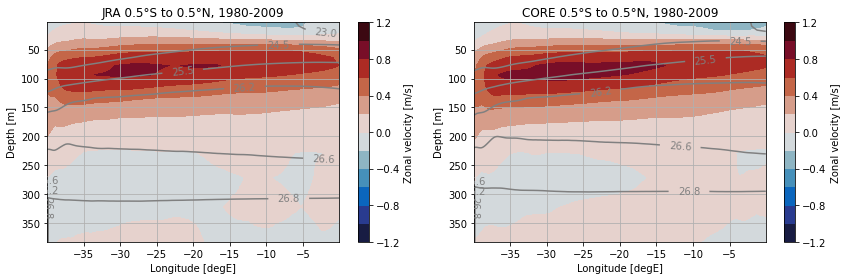

In [23]:
%%time
levs = [23, 24.5,25.5, 26.2, 26.6,26.8]
lev_u=np.arange(-1.2,1.25,.2)

fig,axs = plt.subplots(1,2,figsize=[12,4])

t1 = '1980'
t2 = '2009'

with xr.set_options(keep_attrs=True):
    d = ds_JRA.sigma_0m.swap_dims({'y':'lat'}).sel(lat=slice(-.5,.5),time=slice(t1,t2)).mean('lat').mean('time')
    u = ds_JRA.vozocrtx.swap_dims({'y':'lat'}).sel(lat=slice(-.5,.5),time=slice(t1,t2)).mean('lat').mean('time')
    time = ds_JRA.time.sel(time=slice(t1,t2))
    
u.plot.contourf(ax=axs[0],y='depthu',x='lon_r',yincrease=False,
    levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
dph=d.plot.contour(ax=axs[0],y='deptht',x='lon_c',yincrease=False,levels=levs,colors='grey')
plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
axs[0].set_title('JRA 0.5°S to 0.5°N, %s-%s' % (time[0].dt.strftime('%Y').data,time[-1].dt.strftime('%Y').data))
axs[0].grid()

with xr.set_options(keep_attrs=True):
    d = ds_CORE.sigma_0m.swap_dims({'y':'lat'}).sel(lat=slice(-.5,.5),time=slice(t1,t2)).mean('lat').mean('time')
    u = ds_CORE.vozocrtx.swap_dims({'y':'lat'}).sel(lat=slice(-.5,.5),time=slice(t1,t2)).mean('lat').mean('time')
    time = ds_CORE.time.sel(time=slice(t1,t2))
u.plot.contourf(ax=axs[1],y='depthu',x='lon_r',yincrease=False,
    levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
dph=d.plot.contour(ax=axs[1],y='deptht',x='lon_c',yincrease=False,levels=levs,colors='grey')
plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
axs[1].set_title('CORE 0.5°S to 0.5°N, %s-%s' % (time[0].dt.strftime('%Y').data,time[-1].dt.strftime('%Y').data))
axs[1].grid()

fig.tight_layout()
if savefig:
    tstr1 = '%s' % time[0].dt.strftime('%Y').data
    tstr2 = '%s' % time[-1].dt.strftime('%Y').data
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_1}_mean{tstr1}_{tstr2}{fig_format}"),dpi=300)

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'yincrease'
  # Remove the CWD from sys.path while we load stuff.
/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'yincrease'
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 2.96 s, sys: 2.17 s, total: 5.12 s
Wall time: 1.46 s


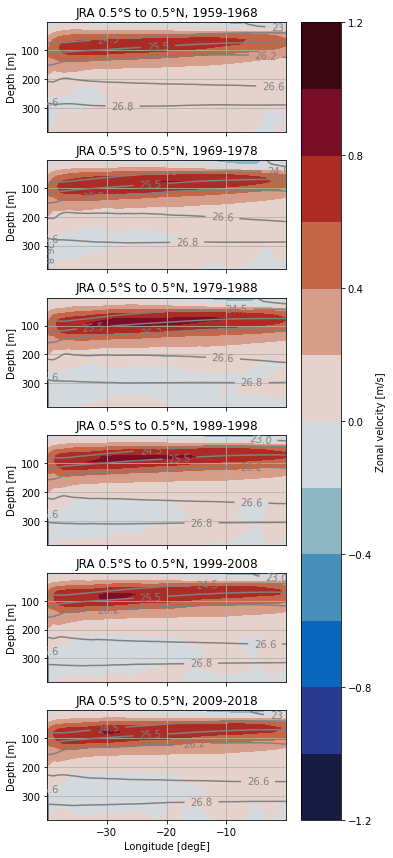

In [24]:
%%time

with xr.set_options(keep_attrs=True):
    d = ds_JRA_10Y.sigma_0m.swap_dims({'y':'lat'}).sel(lat=slice(-.5,.5)).mean('lat')
    u = ds_JRA_10Y.vozocrtx.swap_dims({'y':'lat'}).sel(lat=slice(-.5,.5)).mean('lat')
p = u.isel(t=slice(0,6)).plot.contourf(x='lon_r',y='depthu',col='t',col_wrap=1,aspect=2, size=2,
                                       yincrease=False,
                                       levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
for idx2,ax in enumerate(p.axes.flat):
    dc = d.isel(t=idx2)
    dph=ax.contour(dc.lon_c,dc.deptht,dc,yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
    ax.set_title('JRA 0.5°S to 0.5°N, %s-%s' % (u.t.isel(t=idx2).values, str(u.t.isel(t=idx2).values+9)))
    ax.grid()

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_2}_10Ymeans_{fig_format}"),dpi=300)

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'yincrease'
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 5.91 s, sys: 5.62 s, total: 11.5 s
Wall time: 3.69 s


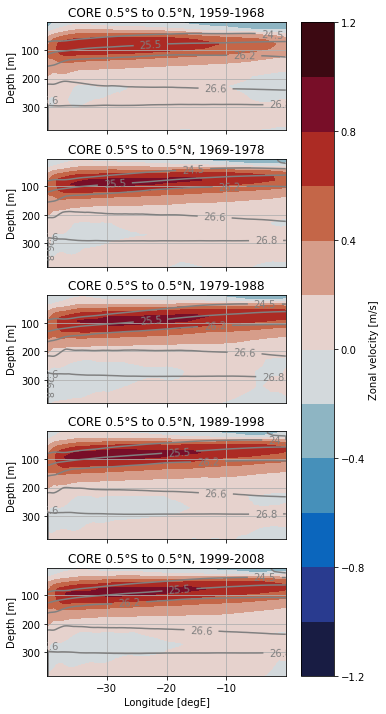

In [25]:
%%time

with xr.set_options(keep_attrs=True):
    d = ds_CORE_10Y.sigma_0m.swap_dims({'y':'lat'}).sel(lat=slice(-.5,.5)).mean('lat')
    u = ds_CORE_10Y.vozocrtx.swap_dims({'y':'lat'}).sel(lat=slice(-.5,.5)).mean('lat')
p = u.isel(t=slice(0,6)).plot.contourf(x='lon_r',y='depthu',col='t',col_wrap=1,aspect=2, size=2,
                                       yincrease=False,
                                       levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
for idx2,ax in enumerate(p.axes.flat):
    dc = d.isel(t=idx2)
    dph=ax.contour(dc.lon_c,dc.deptht,dc,yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
    ax.set_title('CORE 0.5°S to 0.5°N, %s-%s' % (u.t.isel(t=idx2).values, str(u.t.isel(t=idx2).values+9)))
    ax.grid()

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_3}_10Ymeans_{fig_format}"),dpi=300)

## Merdional sections

CPU times: user 6.51 s, sys: 1.25 s, total: 7.76 s
Wall time: 17.4 s


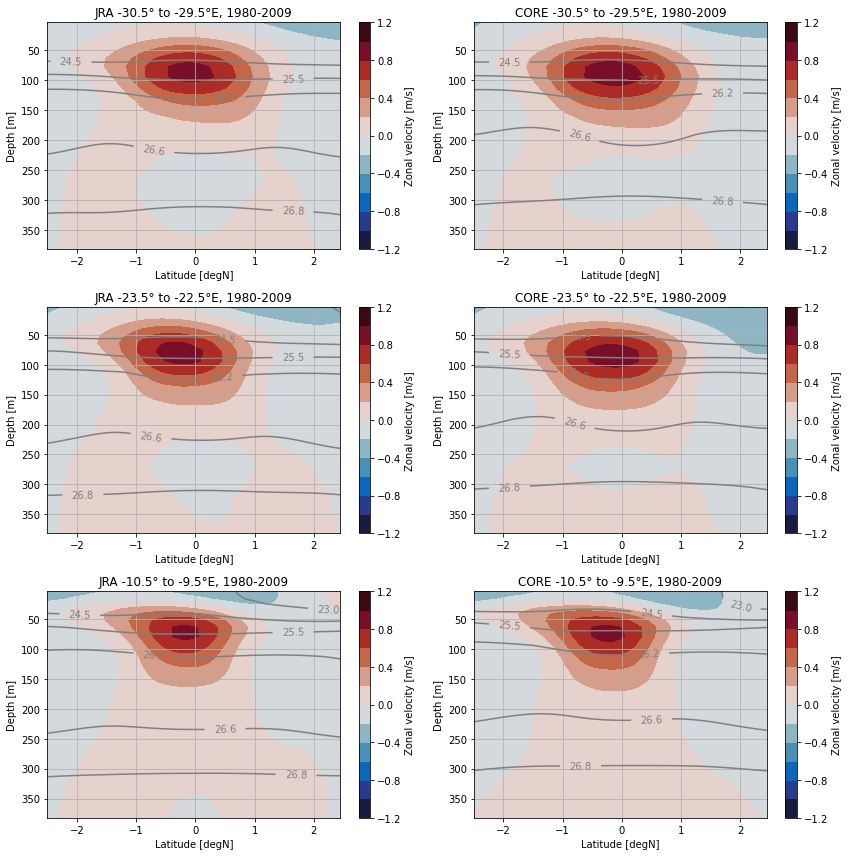

In [26]:
%%time

fig,axs = plt.subplots(3,2,figsize=[12,12])

t1 = '1980'
t2 = '2009'

lon1 = [-30.5, -23.5, -10.5]
lon2 = [-29.5, -22.5, -9.5]

for i,ax in enumerate(axs[:,0]):
    with xr.set_options(keep_attrs=True):
        d = ds_JRA.sigma_0m.swap_dims({'x':'lon_c'}).sel(lon_c=slice(lon1[i],lon2[i]),time=slice(t1,t2)).mean('lon_c').mean('time')
        u = ds_JRA.vozocrtx.swap_dims({'x':'lon_r'}).sel(lon_r=slice(lon1[i],lon2[i]),time=slice(t1,t2)).mean('lon_r').mean('time')
        time = ds_JRA.time.sel(time=slice(t1,t2))

    u.plot.contourf(ax=axs[i,0],y='depthu',x='lat',yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
    dph=d.plot.contour(ax=axs[i,0],y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
    axs[i,0].set_title('JRA %3.1f° to %3.1f°E, %s-%s' % (lon1[i],lon2[i],time[0].dt.strftime('%Y').data,time[-1].dt.strftime('%Y').data))
    axs[i,0].grid()

    with xr.set_options(keep_attrs=True):
        d = ds_CORE.sigma_0m.swap_dims({'x':'lon_c'}).sel(lon_c=slice(lon1[i],lon2[i]),time=slice(t1,t2)).mean('lon_c').mean('time')
        u = ds_CORE.vozocrtx.swap_dims({'x':'lon_r'}).sel(lon_r=slice(lon1[i],lon2[i]),time=slice(t1,t2)).mean('lon_r').mean('time')
        time = ds_CORE.time.sel(time=slice(t1,t2))

    u.plot.contourf(ax=axs[i,1],y='depthu',x='lat',yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
    dph=d.plot.contour(ax=axs[i,1],y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
    axs[i,1].set_title('CORE %3.1f° to %3.1f°E, %s-%s' % (lon1[i],lon2[i],time[0].dt.strftime('%Y').data,time[-1].dt.strftime('%Y').data))
    axs[i,1].grid()

fig.tight_layout()
if savefig:
    tstr1 = '%s' % time[0].dt.strftime('%Y').data
    tstr2 = '%s' % time[-1].dt.strftime('%Y').data
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_4}_mean{tstr1}_{tstr2}{fig_format}"),dpi=300)

CPU times: user 4.46 s, sys: 967 ms, total: 5.43 s
Wall time: 3.92 s


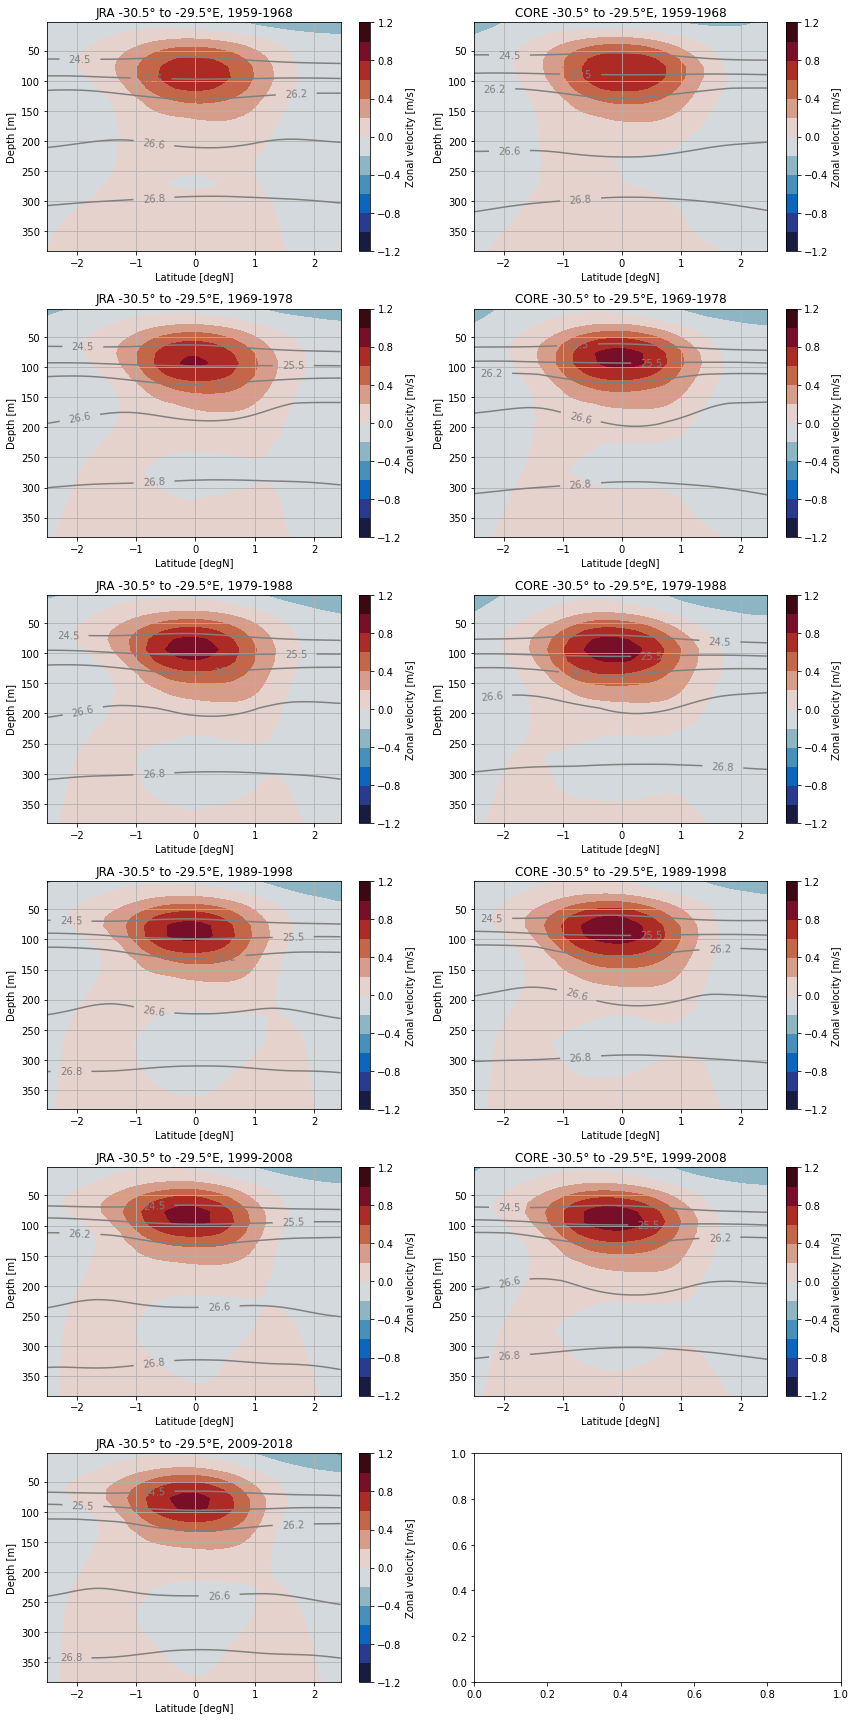

In [27]:
%%time

fig,axs = plt.subplots(6,2,figsize=[12,24])

t1 = '1980'
t2 = '2009'

lon1 = [-30.5, -23.5, -10.5]
lon2 = [-29.5, -22.5, -9.5]

with xr.set_options(keep_attrs=True):
    dc = ds_CORE_10Y.sigma_0m.swap_dims({'x':'lon_c'}).sel(lon_c=slice(lon1[0],lon2[0])).mean('lon_c')
    uc = ds_CORE_10Y.vozocrtx.swap_dims({'x':'lon_r'}).sel(lon_r=slice(lon1[0],lon2[0])).mean('lon_r')
    dj = ds_JRA_10Y.sigma_0m.swap_dims({'x':'lon_c'}).sel(lon_c=slice(lon1[0],lon2[0])).mean('lon_c')
    uj = ds_JRA_10Y.vozocrtx.swap_dims({'x':'lon_r'}).sel(lon_r=slice(lon1[0],lon2[0])).mean('lon_r')

for i,ax in enumerate(axs[:,0]):
    uj.isel(t=i).plot.contourf(ax=axs[i,0],y='depthu',x='lat',yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
    dph=dj.isel(t=i).plot.contour(ax=axs[i,0],y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
    axs[i,0].set_title('JRA %3.1f° to %3.1f°E, %s-%s' % (lon1[0],lon2[0],uj.t.isel(t=i).values, str(uj.t.isel(t=i).values+9)))
    axs[i,0].grid()

    if i<5:
        uc.isel(t=i).plot.contourf(ax=axs[i,1],y='depthu',x='lat',yincrease=False,
            levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
        dph=dc.isel(t=i).plot.contour(ax=axs[i,1],y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
        plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
        axs[i,1].set_title('CORE %3.1f° to %3.1f°E, %s-%s' % (lon1[0],lon2[0],uc.t.isel(t=i).values, str(uc.t.isel(t=i).values+9)))
        axs[i,1].grid()

fig.tight_layout()
if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_4}_10Ymean_30W{fig_format}"),dpi=300)

CPU times: user 4.41 s, sys: 917 ms, total: 5.33 s
Wall time: 3.86 s


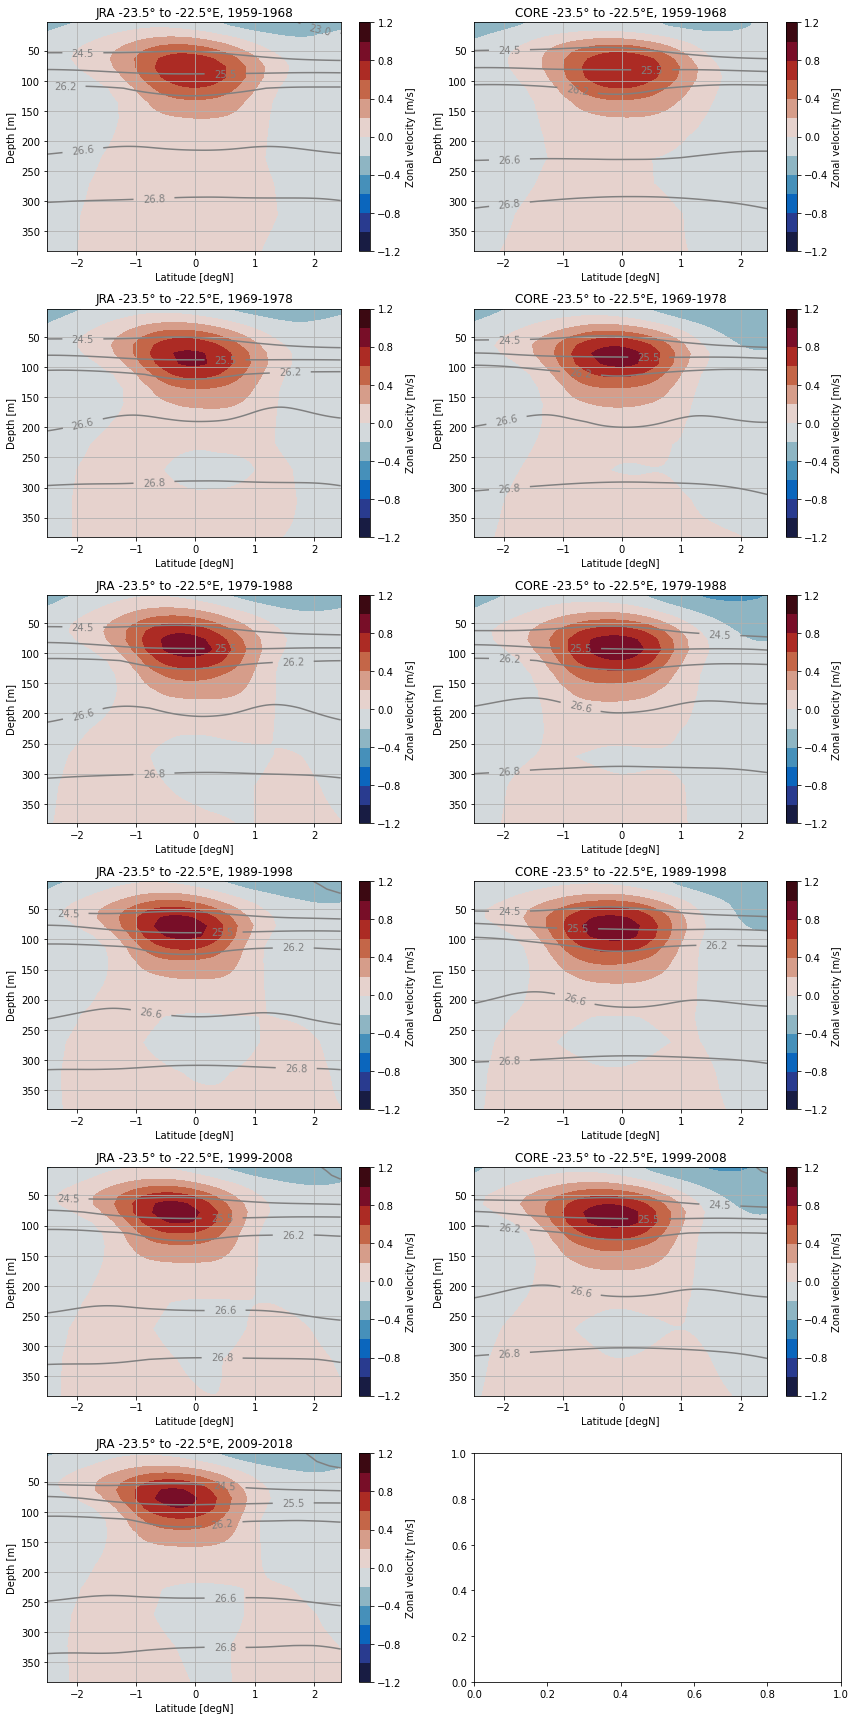

In [28]:
%%time

fig,axs = plt.subplots(6,2,figsize=[12,24])

t1 = '1980'
t2 = '2009'

lon1 = [-30.5, -23.5, -10.5]
lon2 = [-29.5, -22.5, -9.5]

with xr.set_options(keep_attrs=True):
    dc = ds_CORE_10Y.sigma_0m.swap_dims({'x':'lon_c'}).sel(lon_c=slice(lon1[1],lon2[1])).mean('lon_c')
    uc = ds_CORE_10Y.vozocrtx.swap_dims({'x':'lon_r'}).sel(lon_r=slice(lon1[1],lon2[1])).mean('lon_r')
    dj = ds_JRA_10Y.sigma_0m.swap_dims({'x':'lon_c'}).sel(lon_c=slice(lon1[1],lon2[1])).mean('lon_c')
    uj = ds_JRA_10Y.vozocrtx.swap_dims({'x':'lon_r'}).sel(lon_r=slice(lon1[1],lon2[1])).mean('lon_r')

for i,ax in enumerate(axs[:,0]):
    uj.isel(t=i).plot.contourf(ax=axs[i,0],y='depthu',x='lat',yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
    dph=dj.isel(t=i).plot.contour(ax=axs[i,0],y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
    axs[i,0].set_title('JRA %3.1f° to %3.1f°E, %s-%s' % (lon1[1],lon2[1],uj.t.isel(t=i).values, str(uj.t.isel(t=i).values+9)))
    axs[i,0].grid()

    if i<5:
        uc.isel(t=i).plot.contourf(ax=axs[i,1],y='depthu',x='lat',yincrease=False,
            levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
        dph=dc.isel(t=i).plot.contour(ax=axs[i,1],y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
        plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
        axs[i,1].set_title('CORE %3.1f° to %3.1f°E, %s-%s' % (lon1[1],lon2[1],uc.t.isel(t=i).values, str(uc.t.isel(t=i).values+9)))
        axs[i,1].grid()

fig.tight_layout()
if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_4}_10Ymean_23W{fig_format}"),dpi=300)

CPU times: user 4.45 s, sys: 964 ms, total: 5.41 s
Wall time: 3.93 s


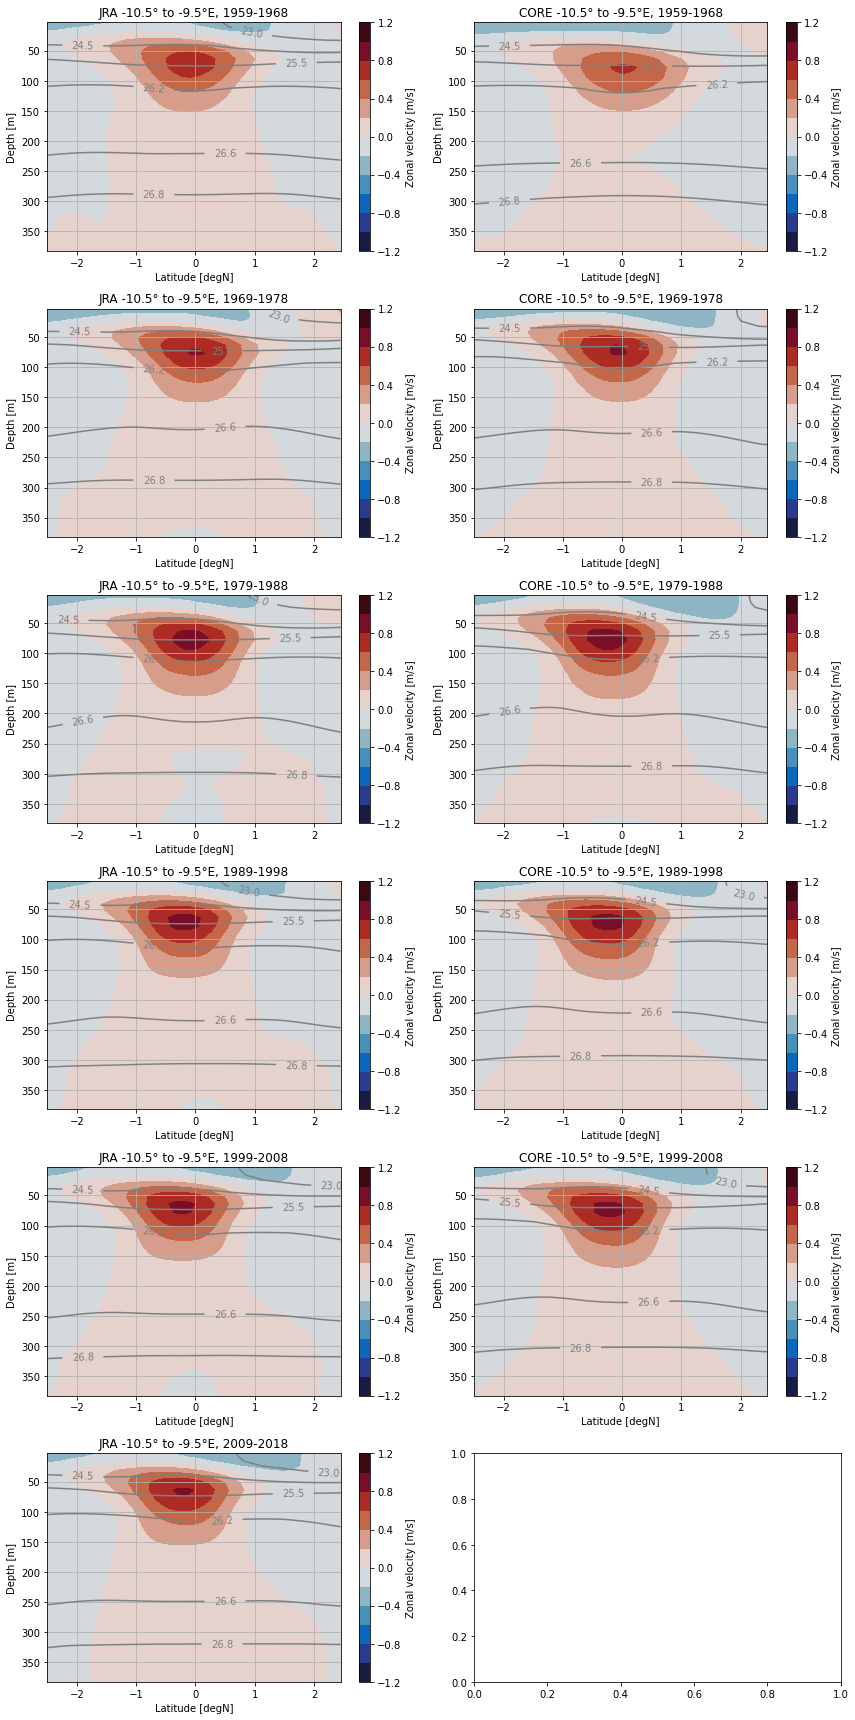

In [29]:
%%time

fig,axs = plt.subplots(6,2,figsize=[12,24])

t1 = '1980'
t2 = '2009'

lon1 = [-30.5, -23.5, -10.5]
lon2 = [-29.5, -22.5, -9.5]

with xr.set_options(keep_attrs=True):
    dc = ds_CORE_10Y.sigma_0m.swap_dims({'x':'lon_c'}).sel(lon_c=slice(lon1[2],lon2[2])).mean('lon_c')
    uc = ds_CORE_10Y.vozocrtx.swap_dims({'x':'lon_r'}).sel(lon_r=slice(lon1[2],lon2[2])).mean('lon_r')
    dj = ds_JRA_10Y.sigma_0m.swap_dims({'x':'lon_c'}).sel(lon_c=slice(lon1[2],lon2[2])).mean('lon_c')
    uj = ds_JRA_10Y.vozocrtx.swap_dims({'x':'lon_r'}).sel(lon_r=slice(lon1[2],lon2[2])).mean('lon_r')

for i,ax in enumerate(axs[:,0]):
    uj.isel(t=i).plot.contourf(ax=axs[i,0],y='depthu',x='lat',yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
    dph=dj.isel(t=i).plot.contour(ax=axs[i,0],y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
    axs[i,0].set_title('JRA %3.1f° to %3.1f°E, %s-%s' % (lon1[2],lon2[2],uj.t.isel(t=i).values, str(uj.t.isel(t=i).values+9)))
    axs[i,0].grid()

    if i<5:
        uc.isel(t=i).plot.contourf(ax=axs[i,1],y='depthu',x='lat',yincrease=False,
            levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance)
        dph=dc.isel(t=i).plot.contour(ax=axs[i,1],y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
        plt.clabel(dph,levels=levs,fmt='%3.1f',fontsize=10)
        axs[i,1].set_title('CORE %3.1f° to %3.1f°E, %s-%s' % (lon1[2],lon2[2],uc.t.isel(t=i).values, str(uc.t.isel(t=i).values+9)))
        axs[i,1].grid()

fig.tight_layout()
if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_4}_10Ymean_10W{fig_format}"),dpi=300)

## Load monthly mean data

In [9]:
CORE_files = list(sorted(
    (out_dir_data.glob(
        f"{nest_prefix}{CORE_exp_id}{'_CORE_1M*.nc'}"
    ))))

JRA_files = list(sorted(
    (out_dir_data.glob(
        f"{nest_prefix}{exp_id[0:-1]}{'X_JRA_1M*.nc'}"
    ))))

print(f"Found {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")

Found 52 CORE files and 61 JRA files.


In [10]:
with dask.config.set(scheduler='synchronous'):
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        concat_dim='time',
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x_c":chu_x,
                 "x_r":chu_x})

In [11]:
with dask.config.set(scheduler='synchronous'):
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        concat_dim='time',
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x_c":chu_x,
                 "x_r":chu_x})

In [14]:
ds_JRA = ds_JRA.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
lon = ds_JRA.glamu.isel(y=5)
ds_JRA = ds_JRA.assign_coords(lon_r=('x_r',lon))
lon = ds_JRA.glamt.isel(y=5)
ds_JRA = ds_JRA.assign_coords(lon_c=('x_c',lon))
lat = ds_JRA.gphit.isel(x_c=400)
ds_JRA = ds_JRA.assign_coords(lat=('y',lat))

ds_CORE = ds_CORE.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
lon = ds_CORE.glamu.isel(y=5)
ds_CORE = ds_CORE.assign_coords(lon_r=('x_r',lon))
lon = ds_CORE.glamt.isel(y=5)
ds_CORE = ds_CORE.assign_coords(lon_c=('x_c',lon))
lat = ds_CORE.gphit.isel(x_c=400)
ds_CORE = ds_CORE.assign_coords(lat=('y',lat))

In [15]:
# set attributes
ds_JRA.depthu.attrs['long_name'] = 'Depth'
ds_JRA.deptht.attrs['long_name'] = 'Depth'
ds_JRA.lat.attrs['units']='degN'
ds_JRA.lat.attrs['long_name']='Latitude'
ds_JRA.lon_r.attrs['units']='degE'
ds_JRA.lon_r.attrs['long_name']='Longitude'
ds_JRA.lon_c.attrs['units']='degE'
ds_JRA.lon_c.attrs['long_name']='Longitude'
ds_JRA.vozocrtx.attrs['long_name'] = 'Zonal velocity'
ds_JRA.vozocrtx.attrs['units'] = 'm/s'

ds_CORE.depthu.attrs['long_name'] = 'Depth'
ds_CORE.deptht.attrs['long_name'] = 'Depth'
ds_CORE.lat.attrs['units']='degN'
ds_CORE.lat.attrs['long_name']='Latitude'
ds_CORE.lon_c.attrs['units']='degE'
ds_CORE.lon_c.attrs['long_name']='Longitude'
ds_CORE.lon_r.attrs['units']='degE'
ds_CORE.lon_r.attrs['long_name']='Longitude'
ds_CORE.vozocrtx.attrs['long_name'] = 'Zonal velocity'
ds_CORE.vozocrtx.attrs['units'] = 'm/s'

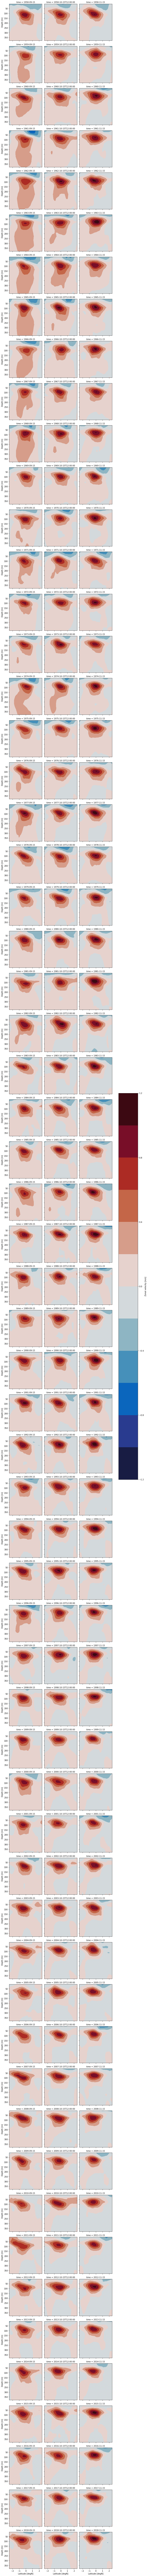

In [29]:
def is_amj(month):
    return (month >= 9) & (month <= 11)

# seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))
lev_u=np.arange(-1.2,1.25,.2)
ds_JRA.sel(time=is_amj(ds_JRA['time.month'])).vozocrtx.swap_dims({'x_r':'lon_r'}).sel(lon_r=-23,method='nearest').plot.contourf(y='depthu',x='lat',col='time',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)

## Calculate monthly means

In [35]:
%%time
tlim1 = '1980'
tlim2 = '2009'
with xr.set_options(keep_attrs=True):
    ds_JRA_clim = ds_JRA.sel(time=slice(tlim1,tlim2)).groupby('time.month').mean(dim='time').compute()
print(ds_JRA_clim.nbytes/1e9,'GB')

0.277419832 GB
CPU times: user 16.2 s, sys: 4.94 s, total: 21.1 s
Wall time: 23 s


In [36]:
%%time
with xr.set_options(keep_attrs=True):
    ds_CORE_clim = ds_CORE.sel(time=slice(tlim1,tlim2)).groupby('time.month').mean(dim='time').compute()
print(ds_CORE_clim.nbytes/1e9,'GB')

0.277419832 GB
CPU times: user 15 s, sys: 8.96 s, total: 23.9 s
Wall time: 25.3 s


## Meridional sections
### JRA

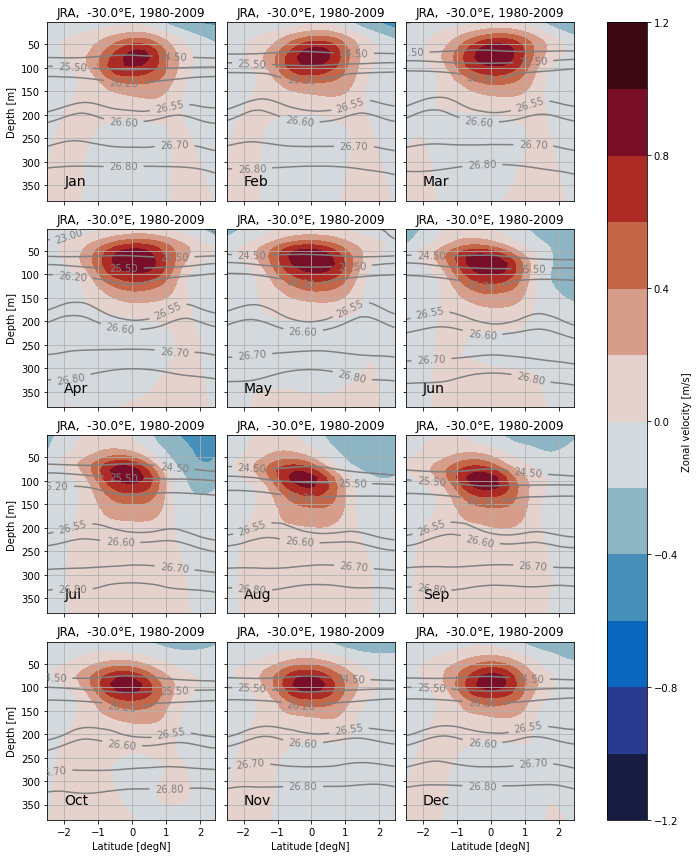

In [37]:
levs = [23, 24.5,25.5, 26.2, 26.55,26.6,26.7,26.8]
lev_u=np.arange(-1.2,1.25,.2)

lon1 = [-30.5, -23.5, -10.5]
lon2 = [-29.5, -22.5, -9.5]
mm_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
idx = 0
with xr.set_options(keep_attrs=True):
    uj = ds_JRA_clim.vozocrtx.swap_dims({'x_r':'lon_r'}).sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_JRA_clim.sigma_0m.swap_dims({'x_c':'lon_c'}).sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('JRA,  %3.1f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (-2,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_5}_clim{tlim1}_{tlim2}_30W{fig_format}"),dpi=300)

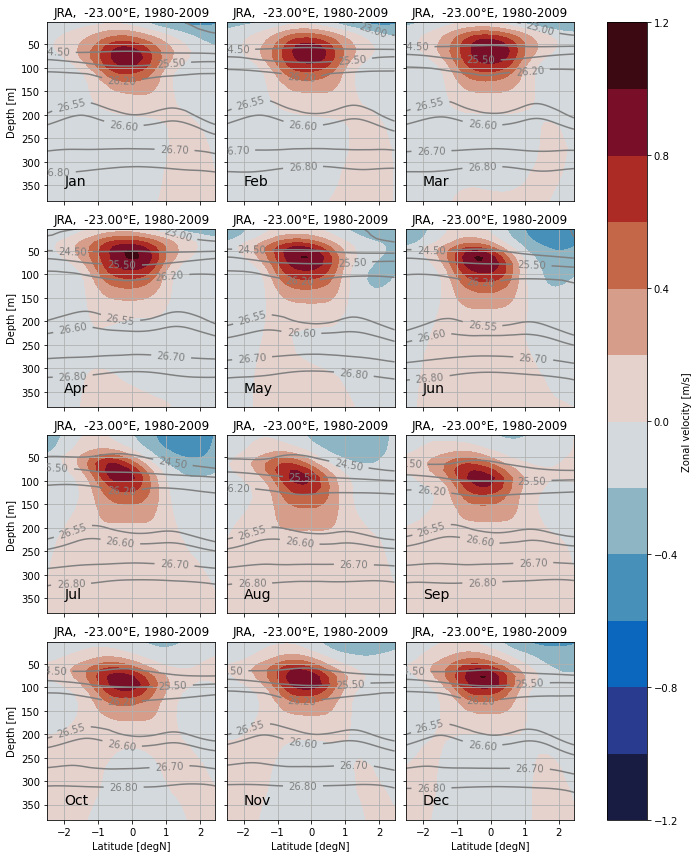

In [38]:
idx = 1
with xr.set_options(keep_attrs=True):
    uj = ds_JRA_clim.vozocrtx.swap_dims({'x_r':'lon_r'}).sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_JRA_clim.sigma_0m.swap_dims({'x_c':'lon_c'}).sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('JRA,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (-2,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_5}_clim{tlim1}_{tlim2}_23W{fig_format}"),dpi=300)

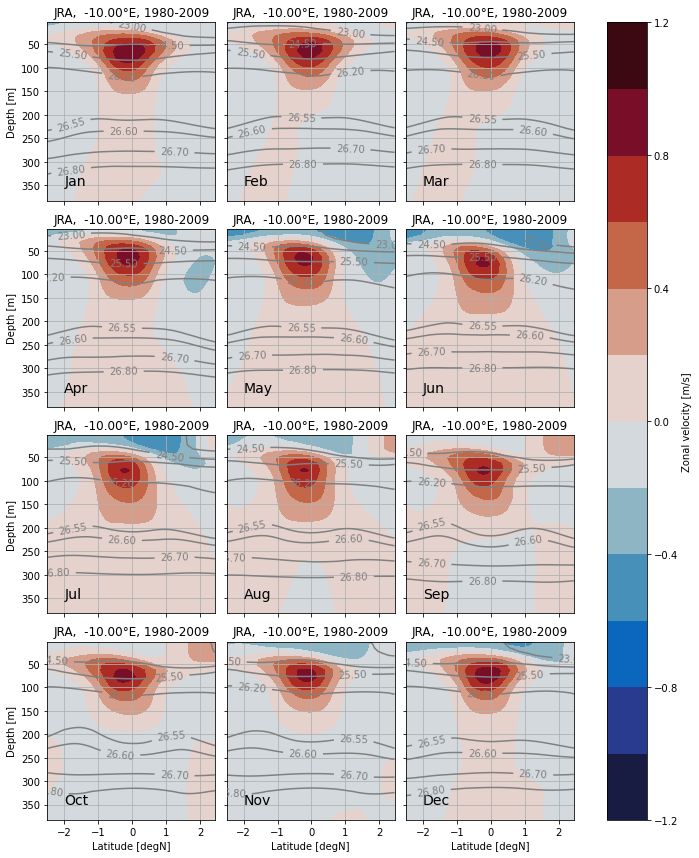

In [39]:
idx = 2
with xr.set_options(keep_attrs=True):
    uj = ds_JRA_clim.vozocrtx.swap_dims({'x_r':'lon_r'}).sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_JRA_clim.sigma_0m.swap_dims({'x_c':'lon_c'}).sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('JRA,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (-2,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_5}_clim{tlim1}_{tlim2}_10W{fig_format}"),dpi=300)

### CORE

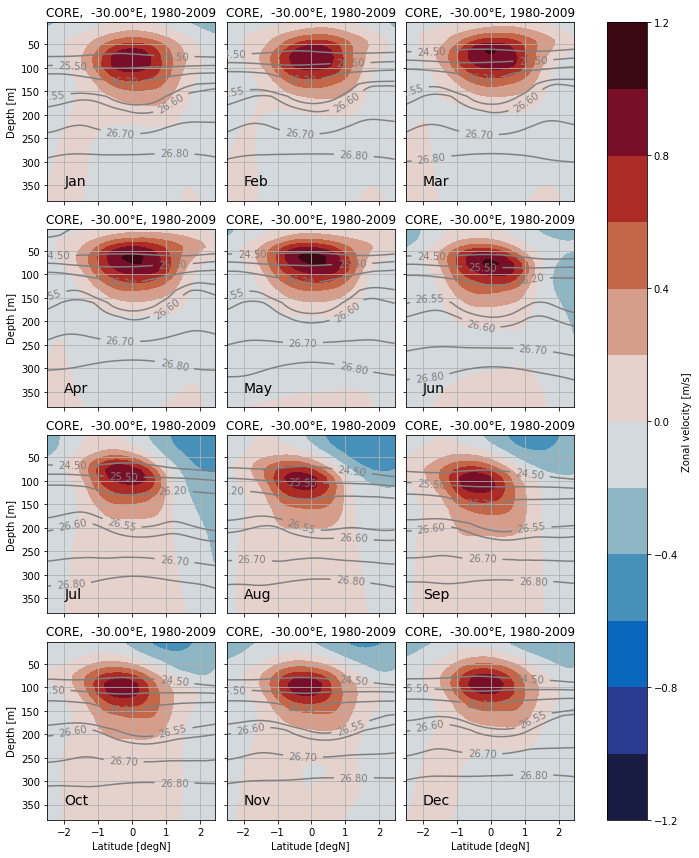

In [40]:
idx = 0
with xr.set_options(keep_attrs=True):
    uj = ds_CORE_clim.vozocrtx.swap_dims({'x_r':'lon_r'}).sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_CORE_clim.sigma_0m.swap_dims({'x_c':'lon_c'}).sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('CORE,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (-2,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_6}_clim{tlim1}_{tlim2}_30W{fig_format}"),dpi=300)

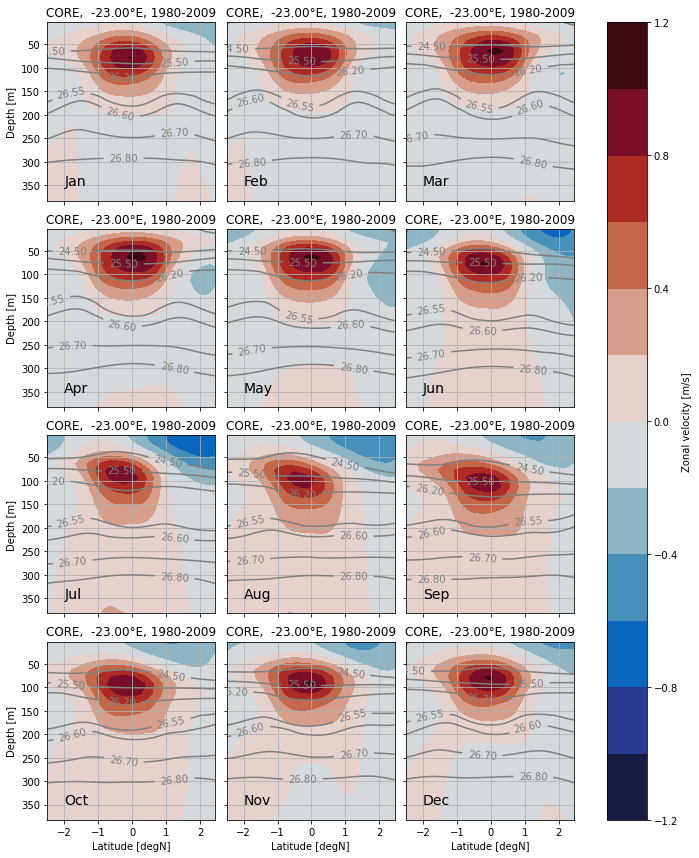

In [41]:
idx = 1
with xr.set_options(keep_attrs=True):
    uj = ds_CORE_clim.vozocrtx.swap_dims({'x_r':'lon_r'}).sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_CORE_clim.sigma_0m.swap_dims({'x_c':'lon_c'}).sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('CORE,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (-2,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_6}_clim{tlim1}_{tlim2}_23W{fig_format}"),dpi=300)

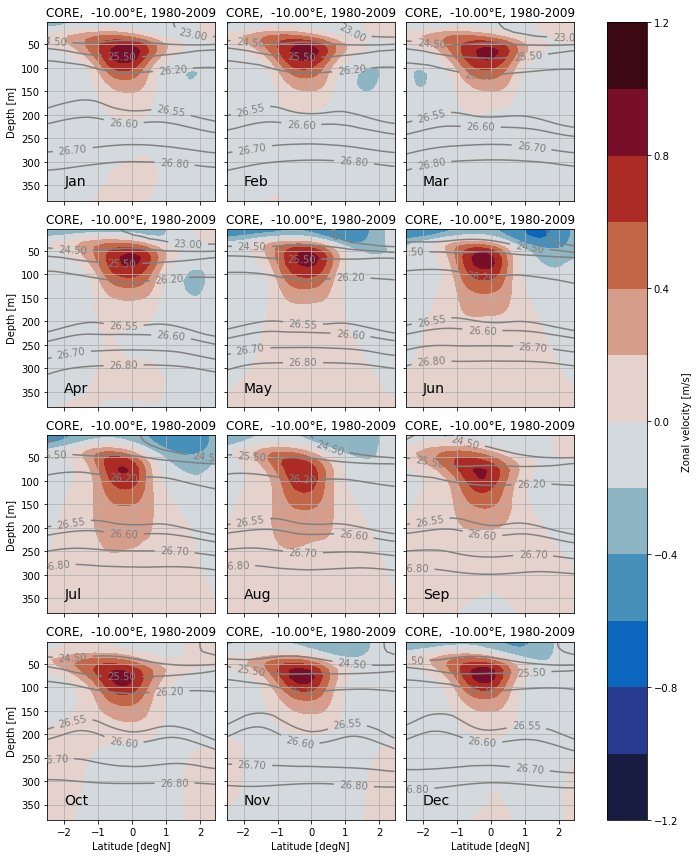

In [42]:
idx = 2
with xr.set_options(keep_attrs=True):
    uj = ds_CORE_clim.vozocrtx.swap_dims({'x_r':'lon_r'}).sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_CORE_clim.sigma_0m.swap_dims({'x_c':'lon_c'}).sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('CORE,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (-2,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_6}_clim{tlim1}_{tlim2}_10W{fig_format}"),dpi=300)